In [208]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math

plt.style.use("mystyle.mplstyle")

num_of_measurements_last_length = 5
num_of_sets = 4
experimenter = "_fil"

logging = True
def log(msg: str):
    if logging: print(msg)

In [209]:
def calc_lin_reg(x: list, y: list, x_errs: list, y_errs: list, m_test: float):
    # y = Ax + B
    N = len(x)

    for i in range(N):
        y_errs[i] = math.sqrt(y_errs[i] ** 2 + m_test**2 * x_errs[i] ** 2)

    sum_x2 = 0
    sum_x = 0
    sum_y = 0
    sum_xy = 0
    sum_sigma_y2 = 0

    for i in range(N):
        sum_x += x[i] / y_errs[i] ** 2
        sum_x2 += x[i] ** 2 / y_errs[i] ** 2
        sum_y += y[i] / y_errs[i] ** 2
        sum_xy += x[i] * y[i] / y_errs[i] ** 2
        sum_sigma_y2 += 1 / (y_errs[i] ** 2)

    delta = sum_sigma_y2 * sum_x2 - sum_x**2
    A = (1 / delta) * (sum_sigma_y2 * sum_xy - sum_x * sum_y)
    B = (1 / delta) * (sum_x2 * sum_y - sum_x * sum_xy)
    sA = math.sqrt((1 / delta) * sum_x2)
    sB = math.sqrt((1 / delta) * sum_sigma_y2)

    sigma_y = []
    for i in range(len(y_errs)):
        sigma_y.append(math.sqrt(y_errs[i] ** 2 + (m_test**2) * (x_errs[i] ** 2)))

    return (A, B, sA, sB, sigma_y)


def calc_chi_sqr(observed, expected, sigma_y, deg_of_freedom: int):
    chi2i = np.divide(np.square(observed - expected), np.square(sigma_y))
    chi2 = np.sum(chi2i)
    chi2r = chi2 / deg_of_freedom
    return (chi2i, chi2, chi2r)

misura fototraguardo lunghezza 1(min)
[!] 0: len = 0.2061, T^2 = 1.5343856816233092 +- 5.2609715985795646e-05
~~~~~~~~~~~~~~~~~~~~~
misura fototraguardo lunghezza 2_tia
[!] 1: len = 0.17258, T^2 = 1.6722248531217774 +- 2.545887024347764e-05
~~~~~~~~~~~~~~~~~~~~~
misura fototraguardo lunghezza 4_tia
[!] 2: len = 0.09912, T^2 = 1.969176048044444 +- 1.748367845579447e-05
~~~~~~~~~~~~~~~~~~~~~
misura fototraguardo lunghezza 5_tia
[!] 3: len = 0.06777333333333334, T^2 = 2.0945465681685755 +- 1.9311432423347948e-05
~~~~~~~~~~~~~~~~~~~~~
misura fototraguardo lunghezza 4_mat
~~~~~~~~~~~~~~~~~~~~~
misura fototraguardo lunghezza 3_tia
[!] 4: len = 0.12758666666666665, T^2 = 1.8551274783584806 +- 2.218415846903938e-05
~~~~~~~~~~~~~~~~~~~~~
misura fototraguardo lunghezza 5_mat
~~~~~~~~~~~~~~~~~~~~~
misura fototraguardo lunghezza 5_fil
~~~~~~~~~~~~~~~~~~~~~
misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi
~~~~~~~~~~~~~~~~~~~~~
misura fototraguardo lunghezza 3_fil
~~~~~~~~~~~~~~~~~~~~~
misura

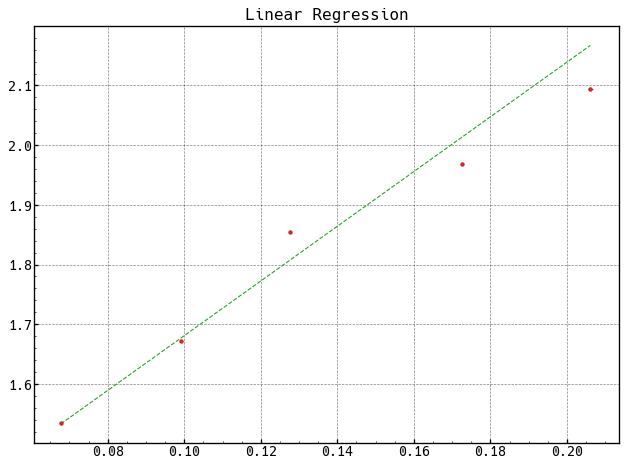

In [210]:
class Measurement:
    def __init__(self, length: float, length_err: float, df: pd.DataFrame):
        self.length = length
        self.length_err = length_err
        self.df = df


mass = 19.88 + 79.56 # supporto + 4 masse
mom_of_inertia = 0


lengths = pd.read_csv("./data/lunghezze.csv", sep=';', decimal=',')
data_sets = dict()
for root, dirs, files in os.walk("./data"):
    for file in files:
        if ".csv" in file and not "lunghezze" in file: # and (experimenter in file or "angoli diversi" in file or "(min)" in file):
            current_file_path = os.path.join(root, file).replace("\\", "/")

            # btw, the data file naming is... not great
            # get the index of the measurement to read the right length from the csv, if there is no number than it's the last measurement... i know...
            try:    idx = int(file.split(' ')[-1][0]) - 1
            except: idx = -1
            
            measured_lengths = list(filter(lambda e: e > 0.0, lengths.iloc[idx,:] * 0.001))
            data_sets[file.rstrip(".csv")] = Measurement(
                np.mean(measured_lengths),
                max((max(measured_lengths) - min(measured_lengths)) / 2.0, 0.00002), # (M-m)/2 or 0.02mm
                pd.read_csv(current_file_path, sep=';', decimal=',')
            )

    break  # stop at first recursion level: only ./data


# print(data_frames["misure fototraguardo, angoli diversi, 3-5-7-10-15 gradi"])


lin_reg_points = np.zeros((num_of_sets, 4)) # L, T^2, e_L, e_T^2
i = 0

for name,data in data_sets.items():
    log(f"{name}")
    
    # first run is always the one used in the linear regression, even in the last recording with multiple angles
    mean_period = np.mean(data.df.iloc[:,1])
    sigma_mean_period = np.std(data.df.iloc[:,1]) / math.sqrt(len(data.df.iloc[:,1]))

    if experimenter in name or "(min)" in name: # or "angoli diversi" in name:
        log(f"[!] {i}: len = {data.length}, T^2 = {mean_period ** 2} +- {sigma_mean_period}")
        lin_reg_points[i,0] = data.length
        lin_reg_points[i,1] = mean_period ** 2
        lin_reg_points[i,2] = data.length_err
        lin_reg_points[i,3] = 2 * mean_period * sigma_mean_period
        i += 1
    
    log("~~~~~~~~~~~~~~~~~~~~~")
    
    # fig, ax = plt.subplots()
    # ax.set_title(f"{name}, {data.length}")
    # if "angoli diversi" in name:
        # for i in range(0,num_of_measurements_last_length):
            # ax.scatter(data.df.iloc[:,2*i], data.df.iloc[:,2*i+1], marker='x')
    # else:
        # ax.scatter(data.df.iloc[:,0], data.df.iloc[:,1], marker='x', c='tab:green')
    # 
    # plt.savefig(f"./out/{name}.png")
    # plt.close()


# linear regression
lin_reg_points.sort(0)

m_test = (lin_reg_points[-1,1] - lin_reg_points[0,1]) / (lin_reg_points[-1,0] - lin_reg_points[0,0])
m, b, err_m, err_b, sigma_y = calc_lin_reg(lin_reg_points[:,0], lin_reg_points[:,1], lin_reg_points[:,2], lin_reg_points[:,3], m_test)
X = np.array([lin_reg_points[0,0], lin_reg_points[-1,0]])
Y = m * X + b

log(f"{lin_reg_points}\nm = {m} +- {err_m}\nb = {b} +- {err_b}\nsigma_y = {sigma_y}")

plt.title("Linear Regression")
plt.errorbar(lin_reg_points[:,0], lin_reg_points[:,1], lin_reg_points[:,3], lin_reg_points[:,2], marker='o', c='tab:red', ls='')
plt.plot(X, Y, ls='--', c='tab:green')
plt.savefig("./out/lin_reg.png")